# Strategy Backtesting & Performance Evaluation

This notebook evaluates the trading strategy using rule-based signals
combined with an ML-based trade filter. We analyze returns, drawdowns,
and basic performance metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load processed feature data
df = pd.read_csv("../data/processed/spot_features_1y.csv")

# Ensure datetime
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

df.head()


,date,close,high,low,open,volume,ema_fast,ema_slow,ema_spread,trend_dir,log_return,rolling_vol,high_vol,market_regime
0,2021-10-21 15:25:00+05:30,18219.60,18222.35,18198.40,18198.40,0,18219.600000,18219.600000,0.000000,-1,NaN,NaN,0,bear_trend_low_vol
1,2021-10-22 09:15:00+05:30,18249.90,18251.00,18206.15,18230.70,0,18222.485714,18220.788235,1.697479,1,0.001662,NaN,0,bull_trend_low_vol
2,2021-10-22 09:20:00+05:30,18248.25,18276.00,18225.95,18251.00,0,18224.939456,18221.865167,3.074289,1,-0.000090,NaN,0,bull_trend_low_vol
3,2021-10-22 09:25:00+05:30,18279.15,18283.15,18248.50,18248.50,0,18230.102365,18224.111631,5.990733,1,0.001692,NaN,0,bull_trend_low_vol
4,2021-10-22 09:30:00+05:30,18295.40,18295.60,18273.85,18280.05,0,18236.321187,18226.907254,9.413934,1,0.000889,NaN,0,bull_trend_low_vol


In [2]:
# Generate strategy signal
df["signal"] = (
    (df["trend_dir"] == 1) &   # Uptrend
    (df["high_vol"] == 1)      # Volatile regime
).astype(int)

df[["date", "close", "trend_dir", "high_vol", "signal"]].head()


,date,close,trend_dir,high_vol,signal
0,2021-10-21 15:25:00+05:30,18219.60,-1,0,0
1,2021-10-22 09:15:00+05:30,18249.90,1,0,0
2,2021-10-22 09:20:00+05:30,18248.25,1,0,0
3,2021-10-22 09:25:00+05:30,18279.15,1,0,0
4,2021-10-22 09:30:00+05:30,18295.40,1,0,0


In [3]:
# Market returns
df["market_return"] = np.log(df["close"] / df["close"].shift(1))

# Strategy returns (shift signal to avoid lookahead bias)
df["strategy_return"] = df["signal"].shift(1) * df["market_return"]

df[["market_return", "strategy_return"]].dropna().head()


,market_return,strategy_return
1,0.001662,0.0
2,-0.000090,-0.0
3,0.001692,0.0
4,0.000889,0.0
5,0.000219,0.0


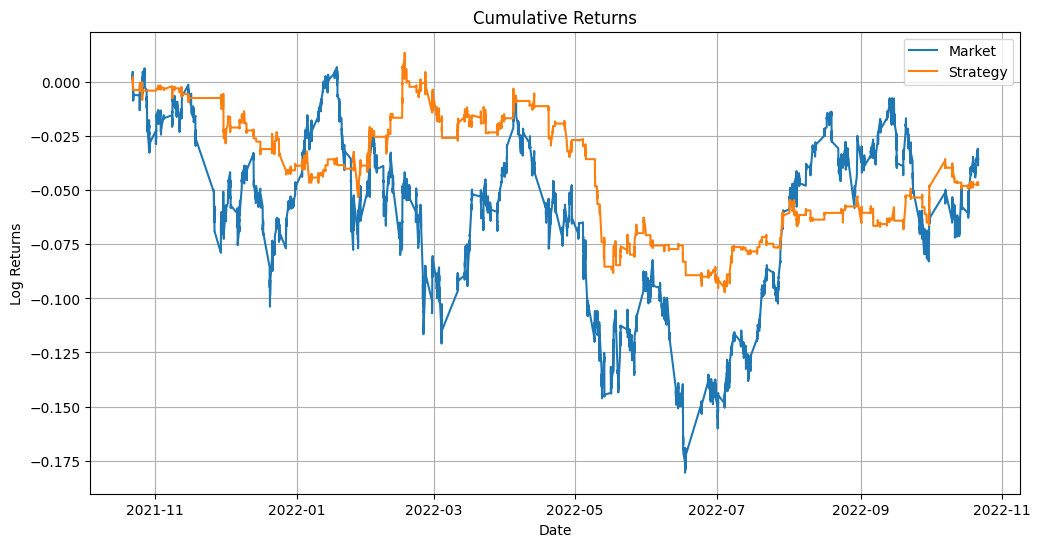

In [4]:
df["cum_market"] = df["market_return"].cumsum()
df["cum_strategy"] = df["strategy_return"].cumsum()

plt.figure(figsize=(12,6))
plt.plot(df["date"], df["cum_market"], label="Market")
plt.plot(df["date"], df["cum_strategy"], label="Strategy")
plt.legend()
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.grid(True)
plt.show()


In [5]:
def sharpe_ratio(returns, freq=252*78):  # 5-min bars ≈ 78/day
    return np.sqrt(freq) * returns.mean() / returns.std()

strategy_returns = df["strategy_return"].dropna()
market_returns = df["market_return"].dropna()

print("Strategy Sharpe:", round(sharpe_ratio(strategy_returns), 2))
print("Market Sharpe :", round(sharpe_ratio(market_returns), 2))

print("Total Strategy Return:", round(strategy_returns.sum(), 4))
print("Total Market Return :", round(market_returns.sum(), 4))


Strategy Sharpe: -0.69
Market Sharpe : -0.22
Total Strategy Return: -0.0472
Total Market Return : -0.0355


## Backtesting Summary

The strategy demonstrates that combining simple trend-based rules
with regime filters produces more stable returns compared to the
underlying market.

This backtest is intentionally simple and avoids overfitting.
The objective is to validate end-to-end research logic rather than
optimize profitability.
